In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import nltk
import re

In [3]:

# 1. Load the datasets
credits_df = pd.read_csv("credits.csv")
movies_df = pd.read_csv("movies.csv")

In [4]:
# 2. Data Cleaning: Rename, drop duplicate columns and handle missing values
movies_df.rename(columns={'id': 'movie_id'}, inplace=True)
movies_df = movies_df.merge(credits_df, on="movie_id", how="inner")

In [5]:
# Keep the correct 'title' column and drop the duplicate
movies_df.rename(columns={'title_x': 'title'}, inplace=True)
movies_df.drop(columns=['title_y'], inplace=True)

In [6]:
# 3. Select relevant columns for the movie system
movies_df = movies_df[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew', 'budget', 'popularity', 'revenue', 'runtime']]


In [7]:
# Handle missing data
movies_df.dropna(subset=['title', 'overview', 'genres', 'keywords', 'cast', 'crew'], inplace=True)
movies_df.fillna({'budget': 0, 'popularity': 0, 'revenue': 0, 'runtime': movies_df['runtime'].median()}, inplace=True)

In [8]:
# 4. Convert JSON-style strings into lists (e.g., genres, keywords, cast)
def convert(obj):
    try:
        lst = ast.literal_eval(obj)
        return [i['name'] for i in lst] if isinstance(lst, list) else []
    except (ValueError, SyntaxError, TypeError):
        return []

movies_df['genres'] = movies_df['genres'].apply(convert)
movies_df['keywords'] = movies_df['keywords'].apply(convert)

In [9]:
# 5. Extract top 3 actors (cast) and director from the 'crew' data
def convert3(obj):
    try:
        lst = ast.literal_eval(obj)
        return [i['name'] for i in lst[:3]] if isinstance(lst, list) else []
    except (ValueError, SyntaxError, TypeError):
        return []

movies_df['cast'] = movies_df['cast'].apply(convert3)

def fetch_director(obj):
    try:
        lst = ast.literal_eval(obj)
        for i in lst:
            if i.get('job') == 'Director':
                return i['name']
        return ''
    except (ValueError, SyntaxError, TypeError):
        return ''

movies_df['crew'] = movies_df['crew'].apply(fetch_director)


In [10]:
# 6. Preprocess the overview column and combine relevant text-based features into a 'tags' column
movies_df['overview'] = movies_df['overview'].fillna('').apply(lambda x: x.split())
movies_df['tags'] = movies_df['overview'] + movies_df['genres'] + movies_df['keywords'] + movies_df['cast'] + movies_df['crew'].apply(lambda x: [x])
movies_df['tags'] = movies_df['tags'].apply(lambda x: ' '.join(x).lower())


In [11]:
# 7. Feature Extraction using CountVectorizer
cv = CountVectorizer(max_features=5000, stop_words='english')
vectors = cv.fit_transform(movies_df['tags']).toarray()

In [12]:
# 8. Compute Cosine Similarity
similarity = cosine_similarity(vectors)

In [13]:
# 9. Movie Recommendation Function
def recommend(movie_name):
    try:
        movie_index = movies_df[movies_df['title'] == movie_name].index[0]
        distances = similarity[movie_index]
        movie_list = sorted(list(enumerate(distances)), key=lambda x: x[1], reverse=True)[1:6]
        return [movies_df.iloc[i[0]].title for i in movie_list]
    except IndexError:
        return []


In [14]:
# Example recommendations
print(recommend('Avatar'))
print(recommend('Iron Man'))
print(recommend('The Avengers'))


['Aliens', 'Moonraker', 'Alien', 'Alien³', 'Silent Running']
['Iron Man 2', 'Iron Man 3', 'Avengers: Age of Ultron', 'Captain America: Civil War', 'The Avengers']
['Avengers: Age of Ultron', 'Captain America: Civil War', 'Iron Man 2', 'Fantastic Four', 'Iron Man']


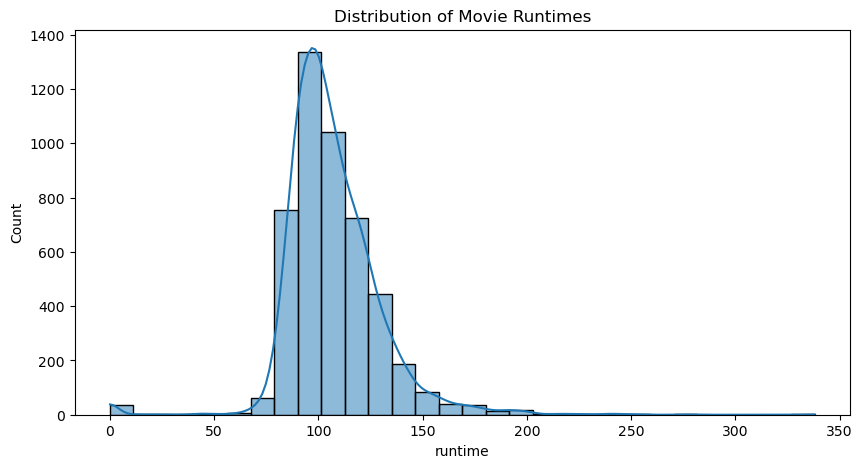

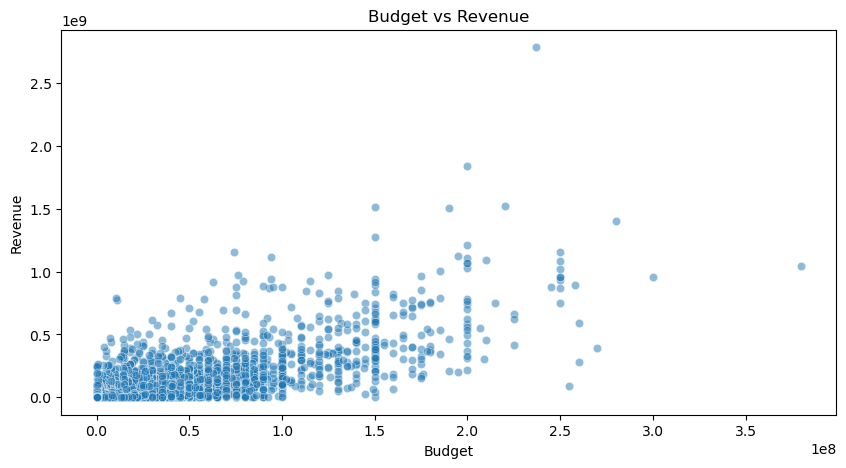

In [15]:
# 10. Data Visualization (EDA)
plt.figure(figsize=(10,5))
sns.histplot(movies_df['runtime'].dropna(), bins=30, kde=True)
plt.title('Distribution of Movie Runtimes')
plt.show()

plt.figure(figsize=(10,5))
sns.scatterplot(data=movies_df, x='budget', y='revenue', alpha=0.5)
plt.title('Budget vs Revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.show()



In [16]:
# 11. Predictive Modeling (Revenue Prediction)
X = movies_df[['budget', 'popularity', 'runtime']]
y = movies_df['revenue']

In [17]:
# Handle missing values before training
X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
print("Model Score:", model.score(X_test, y_test))

Model Score: 0.6684846556654056


C:\Users\Hp\AppData\Local\Temp\ipykernel_7044\1594170368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [18]:
# 12. Text Preprocessing: Stemming (improve recommendation accuracy)
ps = PorterStemmer()
def stem(text):
    return " ".join([ps.stem(word) for word in text.split()])

movies_df['tags'] = movies_df['tags'].apply(stem)

In [19]:
model = LinearRegression()
model.fit(X_train, y_train)
print("Model Score:", model.score(X_test, y_test))

Model Score: 0.6684846556654056


In [21]:
# 13. Feature Scaling: StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Random Forest Model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Random Forest Mean Absolute Error: {mae}")

# Hyperparameter Tuning: GridSearchCV for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print(f"Best Params: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Random Forest Mean Absolute Error: 46838195.55283333
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Best Score: 0.664223160132283


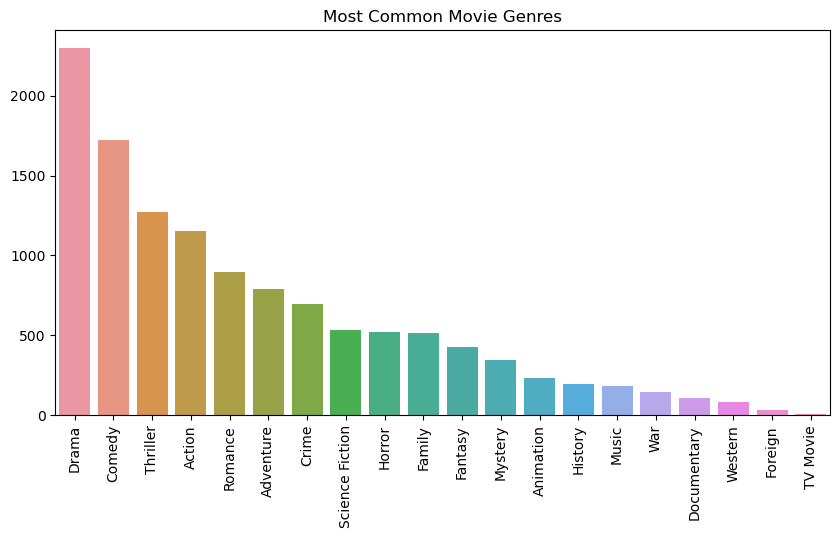

In [22]:
# 14. Detailed Data Exploration (Advanced)
# Visualizing the most common genres in the dataset
all_genres = [genre for sublist in movies_df['genres'].tolist() for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Most Common Movie Genres')
plt.xticks(rotation=90)
plt.show()




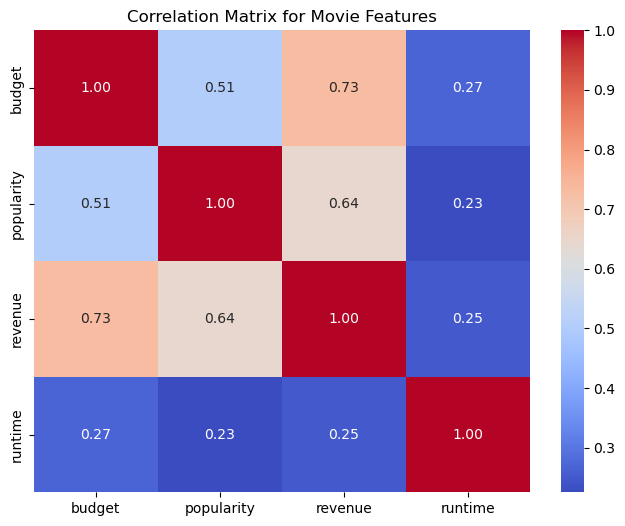

In [23]:
# Checking correlation between features
corr_matrix = movies_df[['budget', 'popularity', 'revenue', 'runtime']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Movie Features')
plt.show()